# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
def grow_tree(data, min_samples_split=2, max_depth=2, depth=0):
    
    X = data[:, :-1]
    Y = data[:, -1]
    n_samples, n_features = np.shape(X)
    
    best_split = find_best_split(data, n_samples, n_features)

    if (stop_min_samples(n_samples, min_samples_split) or stop_pure_label(Y) or 
        stop_max_depth(depth, max_depth) or stop_if_unbalanced_stop(Y) or best_split["info_gain"] <= 0):
        leaf_value = createLeafValue(Y) 
        return {"value": leaf_value}  # Return a leaf node
    

    if best_split["info_gain"] > 0:
        left_subtree = grow_tree(best_split["dataset_left"], min_samples_split, max_depth, depth + 1)
        right_subtree = grow_tree(best_split["dataset_right"], min_samples_split, max_depth, depth + 1)
        return {
            "feature_index": best_split["feature_index"],
            "threshold": best_split["threshold"],
            "left": left_subtree,
            "right": right_subtree,
            "info_gain": best_split["info_gain"]
        }

def createLeafValue(Y):
    Y = list(Y)
    most_frequent=max(Y, key=Y.count)
    return most_frequent

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [3]:
# TODO: Change the name of the functions and implement them as you see fit.

def stop_pure_label(labels):
    return len(np.unique(labels)) == 1

def stop_max_depth(depth, max_depth):
        return depth >= max_depth 

def stop_min_samples(n_samples, min_samples_split):
        return n_samples < min_samples_split 

def stop_if_unbalanced_stop(labels):
    labels = labels.astype(int)
    imbalance_threshold = 0.9
    max_class_ratio = np.max(np.bincount(labels)) / len(labels)
    if max_class_ratio >= imbalance_threshold:
        return True
    return False



### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [4]:
def find_best_split(dataset, n_samples, n_features):
    best_split = {}
    max_info_gain = -float("inf")

    for feature_index in range(n_features):
        feature_values = dataset[:, feature_index]
        is_numerical = np.issubdtype(feature_values.dtype, np.number)

        if is_numerical: #numerical
            thresholds = [np.mean(feature_values)]
        else: #categorical
            thresholds = np.unique(feature_values)

        for threshold in thresholds:
            left, right = split_data(dataset, feature_index, threshold)
            if len(left) > 0 and len(right) > 0:
                parent, left_labels, right_labels = dataset[:, -1], left[:, -1], right[:, -1]
                
                # Calculating the information gain
                current_info_gain = information_gain(parent, left_labels, right_labels)
                if current_info_gain > max_info_gain:
                    best_split["feature_index"] = feature_index
                    best_split["threshold"] = threshold
                    best_split["dataset_left"] = left
                    best_split["dataset_right"] = right
                    best_split["info_gain"] = current_info_gain
                    max_info_gain = current_info_gain

    return best_split

def information_gain(parent_entropy, left_labels, right_labels):
    p_left = len(left_labels) / len(parent_entropy)
    p_right = len(right_labels) / len(parent_entropy)

    gain = gini_index(parent_entropy) - (p_left * gini_index(left_labels) + p_right * gini_index(right_labels))

    return gain

def gini_index(labels):
    target_labels = np.unique(labels)
    gini_val = 0

    for i in target_labels:
        p_target = len(labels[labels == i]) / len(labels)
        gini_val += p_target ** 2
        
    gini_val=1-gini_val

    return gini_val

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [5]:
def split_data(dataset, feature_index,threshold):
    
    feature_values = dataset[:, feature_index]
    is_numerical = np.issubdtype(feature_values.dtype, np.number)

    if is_numerical:
        threshold = np.mean(feature_values)

    dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
    dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])

    return dataset_left, dataset_right


### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [6]:
def predict_with_tree(datapoint, tree):

    # TODO: Implement the rest of this function.
    # NOTE: This function should also be recursive.

    predictions = []
    for x in datapoint:
        predictions.append(make_prediction(x, tree))
    return predictions

def make_prediction(x, tree):
    if tree.get("value") is not None:
        return tree["value"]

    feature_val = x[tree["feature_index"]]
    if feature_val <= tree["threshold"]:
        return make_prediction(x, tree["left"])
    else:
        return make_prediction(x, tree["right"])


## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [7]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [8]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

Wine Dataset Decision Tree Testing
Custom model Accuracy 'Wine-Dataset' Run 1 0.8571428571428571
Scikit-learn Accuracy 'Wine-Dataset' Run 1: 0.9714 
Custom model Accuracy 'Wine-Dataset' Run 2 0.9428571428571428
Scikit-learn Accuracy 'Wine-Dataset' Run 2: 0.9429 
Custom model Accuracy 'Wine-Dataset' Run 3 0.8571428571428571
Scikit-learn Accuracy 'Wine-Dataset' Run 3: 0.8571 
Custom model Accuracy 'Wine-Dataset' Run 4 0.9428571428571428
Scikit-learn Accuracy 'Wine-Dataset' Run 4: 0.9714 
Custom model Accuracy 'Wine-Dataset' Run 5 0.9142857142857143
Scikit-learn Accuracy 'Wine-Dataset' Run 5: 0.9429 


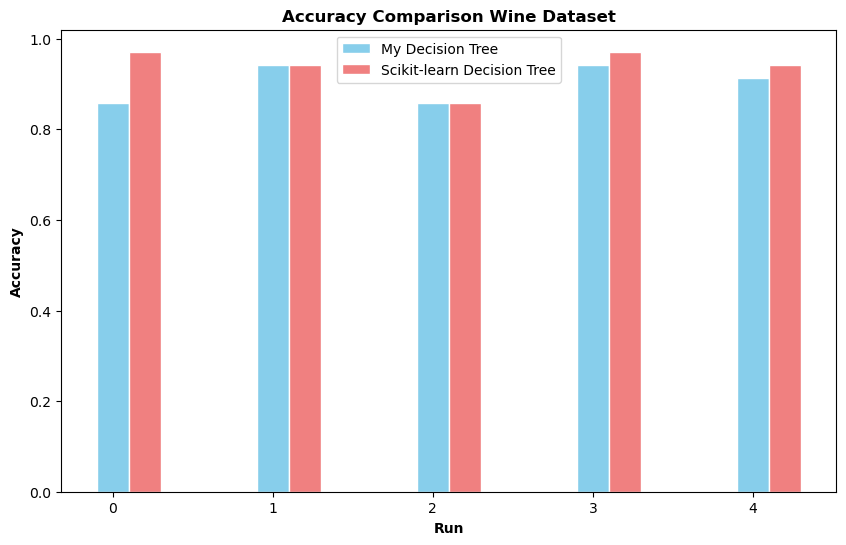

In [9]:
data_wine = pd.read_csv("wine.csv")
data_wine=data_wine.drop(0)

print('Wine Dataset Decision Tree Testing')

sklearn_accuracies = []
my_accuracies = [] 

# TODO: Set up the data and split it into train and test-sets.
for i in range(5):
    
    data_wine = data_wine.sample(frac=1).reset_index(drop=True)
    features = data_wine.iloc[:, :-1].values 
    labels = data_wine.iloc[:, -1].values.reshape(-1, 1)
    
    #Splitting test and train data
    split_size = int(0.2*len(data_wine))
    features_test,labels_test = features[:split_size],labels[:split_size]
    features_train,labels_train = features[split_size:],labels[split_size:]

    training_wine_data=np.concatenate((features_train, labels_train), axis=1)
    tree = grow_tree(training_wine_data, min_samples_split=3, max_depth=4)

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

    labels_prediction = predict_with_tree(features_test, tree)
    my_accuracy = accuracy_score(labels_test,labels_prediction)   
    my_accuracies.append(my_accuracy)
    print("Custom model Accuracy 'Wine-Dataset' Run",i+1, my_accuracy)
    
    
# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model   
    
    clf = DecisionTreeClassifier(min_samples_split=3, max_depth=4, random_state=42) #random_state for reproducibility
    clf.fit(features_train, labels_train)
    sklearn_predictions = clf.predict(features_test)
    sklearn_accuracy = accuracy_score(labels_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)
    print(f"Scikit-learn Accuracy 'Wine-Dataset' Run {i+1}: {sklearn_accuracy:.4f} ")

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 6))
barWidth = 0.2  
r1 = np.arange(len(my_accuracies))
r2 = [x + barWidth for x in r1]
plt.bar(r1, my_accuracies, color='skyblue', width=barWidth, edgecolor='white', label='My Decision Tree')
plt.bar(r2, sklearn_accuracies, color='lightcoral', width=barWidth, edgecolor='white', label='Scikit-learn Decision Tree')
plt.xlabel('Run', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison Wine Dataset', fontweight='bold')
plt.legend()
plt.show()

### 7) Dataset 2: Heart Disease

Heart Dataset Decision Tree Testing
Custom model Accuracy 'Heart Dataset' Run 1 0.8578431372549019
Scikit-learn Accuracy 'Heart-Dataset' Run 1: 0.8922 
Custom model Accuracy 'Heart Dataset' Run 2 0.7892156862745098
Scikit-learn Accuracy 'Heart-Dataset' Run 2: 0.8578 
Custom model Accuracy 'Heart Dataset' Run 3 0.8235294117647058
Scikit-learn Accuracy 'Heart-Dataset' Run 3: 0.8333 
Custom model Accuracy 'Heart Dataset' Run 4 0.8578431372549019
Scikit-learn Accuracy 'Heart-Dataset' Run 4: 0.8382 
Custom model Accuracy 'Heart Dataset' Run 5 0.8431372549019608
Scikit-learn Accuracy 'Heart-Dataset' Run 5: 0.8676 


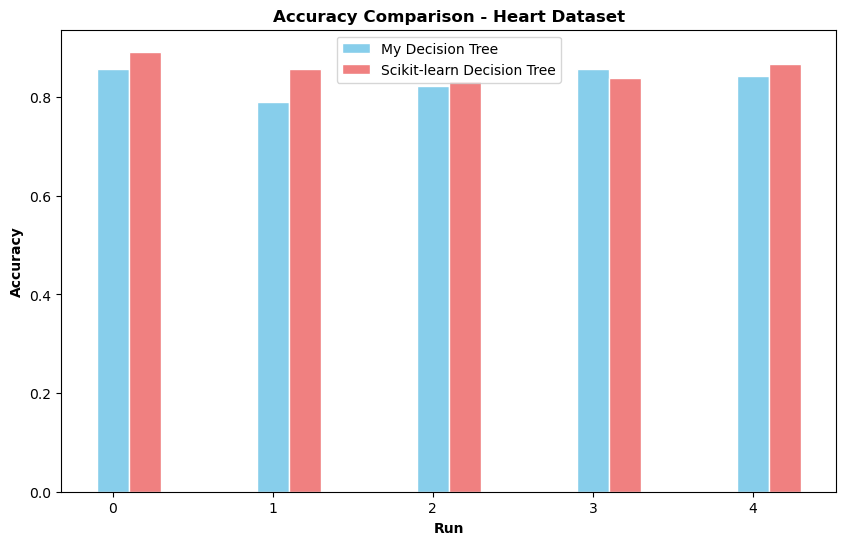

In [10]:
data_heart = pd.read_csv("heart.csv")
data_heart = data_heart.drop(0)
print('Heart Dataset Decision Tree Testing')

sklearn_accuracies = []
my_accuracies = [] 

# TODO: Set up the data and split it into train and test-sets.
for i in range(5):
    
    data_heart = data_heart.sample(frac=1).reset_index(drop=True)
    features = data_heart.iloc[:, :-1].values 
    labels = data_heart.iloc[:, -1].values.reshape(-1, 1)
    split_size = int(0.2*len(data_heart))
    
    #Splitting test and train data
    features_test,labels_test = features[:split_size],labels[:split_size]
    features_train,labels_train = features[split_size:],labels[split_size:]

    training_heart_data=np.concatenate((features_train, labels_train), axis=1)
    tree = grow_tree(training_heart_data, min_samples_split=3, max_depth=4)

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

    labels_prediction = predict_with_tree(features_test, tree)

    my_accuracy = accuracy_score(labels_test,labels_prediction)   
    my_accuracies.append(my_accuracy)
    print("Custom model Accuracy 'Heart Dataset' Run",i+1, my_accuracy)
    
    
# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model   
    
    clf = DecisionTreeClassifier(min_samples_split=3, max_depth=4, random_state=42) #random_state for reproducibility
    clf.fit(features_train, labels_train)
    sklearn_predictions = clf.predict(features_test)
    sklearn_accuracy = accuracy_score(labels_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)
    print(f"Scikit-learn Accuracy 'Heart-Dataset' Run {i+1}: {sklearn_accuracy:.4f} ")
    
# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 6))
barWidth = 0.2 
r1 = np.arange(len(my_accuracies))
r2 = [x + barWidth for x in r1]
plt.bar(r1, my_accuracies, color='skyblue', width=barWidth, edgecolor='white', label='My Decision Tree')
plt.bar(r2, sklearn_accuracies, color='lightcoral', width=barWidth, edgecolor='white', label='Scikit-learn Decision Tree')
plt.xlabel('Run', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison - Heart Dataset', fontweight='bold')
plt.legend()
plt.show()


### 8) Dataset 3: Car

Car Dataset Decision Tree Testing
Custom model Accuracy 'Car Dataset' Run 1 0.8144927536231884
Scikit-learn Accuracy 'Car Dataset' Run 1: 0.8348 
Custom model Accuracy 'Car Dataset' Run 2 0.8
Scikit-learn Accuracy 'Car Dataset' Run 2: 0.7971 
Custom model Accuracy 'Car Dataset' Run 3 0.7942028985507247
Scikit-learn Accuracy 'Car Dataset' Run 3: 0.8174 
Custom model Accuracy 'Car Dataset' Run 4 0.7884057971014493
Scikit-learn Accuracy 'Car Dataset' Run 4: 0.8000 
Custom model Accuracy 'Car Dataset' Run 5 0.8
Scikit-learn Accuracy 'Car Dataset' Run 5: 0.8058 


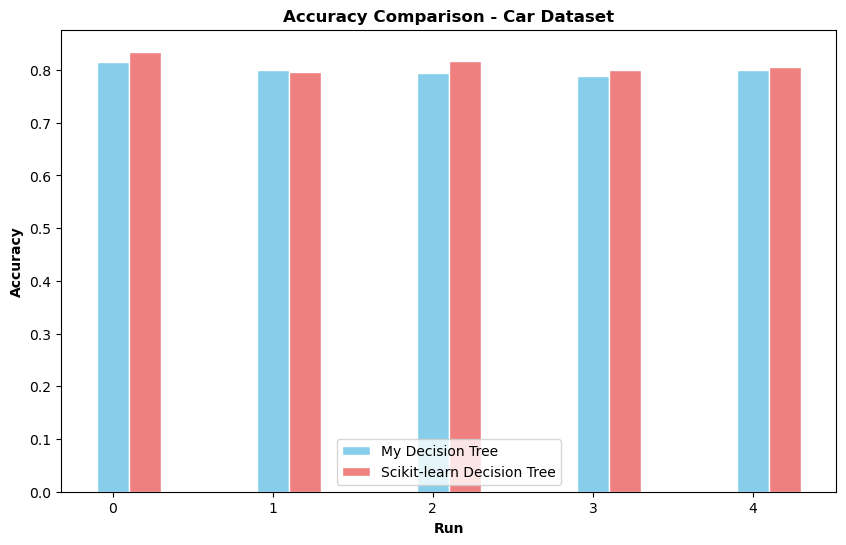

In [11]:
from sklearn.preprocessing import LabelEncoder
data_car = pd.read_csv("car.csv")
data_car = data_car.drop(0)

# Encoding using label encoder
label_encoders = {}
for column in data_car.columns:
    encoder = LabelEncoder()
    data_car[column] = encoder.fit_transform(data_car[column])
    label_encoders[column] = encoder

sklearn_accuracies = []
my_accuracies = [] 

print('Car Dataset Decision Tree Testing')

for i in range(5):
    
    data_car = data_car.sample(frac=1).reset_index(drop=True)
    features = data_car.iloc[:, :-1].values 
    labels = data_car.iloc[:, -1].values.reshape(-1, 1)
    split_size = int(0.2*len(data_car))
    
    #Splitting test and train data
    features_test,labels_test = features[:split_size],labels[:split_size]
    features_train,labels_train = features[split_size:],labels[split_size:]

    training_car_data=np.concatenate((features_train, labels_train), axis=1)
    tree = grow_tree(training_car_data, min_samples_split=3, max_depth=4)

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model

    labels_prediction = predict_with_tree(features_test, tree)

    my_accuracy = accuracy_score(labels_test,labels_prediction)   
    my_accuracies.append(my_accuracy)
    print("Custom model Accuracy 'Car Dataset' Run",i+1, my_accuracy)
    
    # TODO: Train and test scikit learns tree model.
    # NOTE: Use the same train/test split for your tree model and the scikit learn model   
    
    clf = DecisionTreeClassifier(min_samples_split=3, max_depth=4, random_state=42) #random_state for reproducibility
    clf.fit(features_train, labels_train)
    sklearn_predictions = clf.predict(features_test)
    sklearn_accuracy = accuracy_score(labels_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)
    print(f"Scikit-learn Accuracy 'Car Dataset' Run {i+1}: {sklearn_accuracy:.4f} ")
    
# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
plt.figure(figsize=(10, 6))
barWidth = 0.2 
r1 = np.arange(len(my_accuracies))
r2 = [x + barWidth for x in r1]
plt.bar(r1, my_accuracies, color='skyblue', width=barWidth, edgecolor='white', label='My Decision Tree')
plt.bar(r2, sklearn_accuracies, color='lightcoral', width=barWidth, edgecolor='white', label='Scikit-learn Decision Tree')
plt.xlabel('Run', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison - Car Dataset', fontweight='bold')
plt.legend()
plt.show()


### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Scikit-learn Accuracy (no preprocessing) Run 1: 0.9167
Custom Tree Accuracy (no preprocessing) Run 1: 0.8611
Scikit-learn Accuracy (with preprocessing) Run 1: 0.9167
Custom Tree Accuracy (with preprocessing) Run 1: 0.8611
Scikit-learn Accuracy (no preprocessing) Run 2: 0.9444
Custom Tree Accuracy (no preprocessing) Run 2: 0.8333
Scikit-learn Accuracy (with preprocessing) Run 2: 0.9444
Custom Tree Accuracy (with preprocessing) Run 2: 0.8333
Scikit-learn Accuracy (no preprocessing) Run 3: 0.9444
Custom Tree Accuracy (no preprocessing) Run 3: 0.9167
Scikit-learn Accuracy (with preprocessing) Run 3: 0.9444
Custom Tree Accuracy (with preprocessing) Run 3: 0.9167
Scikit-learn Accuracy (no preprocessing) Run 4: 0.9167
Custom Tree Accuracy (no preprocessing) Run 4: 0.9167
Scikit-learn Accuracy (with preprocessing) Run 4: 0.9167
Custom Tree Accuracy (with preprocessing) Run 4: 0.9167
Scikit-learn Accuracy (no preprocessing) Run 5: 0.9167
Custom Tree Accuracy (no preprocessing) Run 5: 0.8889
Sci

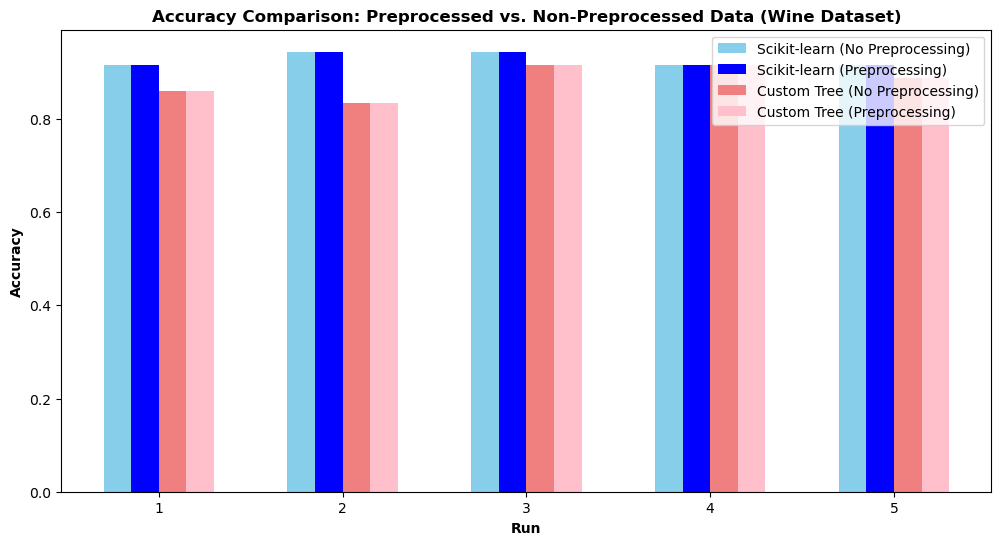

Average Scikit-learn Accuracy (No Preprocessing): 0.9278
Average Scikit-learn Accuracy (With Preprocessing): 0.9278
Average Custom Tree Accuracy (No Preprocessing): 0.8833
Average Custom Tree Accuracy (With Preprocessing): 0.8833


In [12]:
from sklearn import preprocessing

data_wine = pd.read_csv("wine.csv")
data_wine = data_wine.drop(0)

preprocessed_data_accuracies = [] 
no_processing_data_accuracies = []   
sklearn_accuracies = []
sklearn_preprocessed_accuracies = []

for i in range(5):
    data_wine_shuffled = data_wine.sample(frac=1).reset_index(drop=True)
    features = data_wine_shuffled.iloc[:, :-1].values
    labels = data_wine_shuffled.iloc[:, -1].values.reshape(-1, 1)
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=i) # different random_state for each iteration

    # Scikit-learn (no preprocessing)
    clf = DecisionTreeClassifier(min_samples_split=3, max_depth=4, random_state=42)
    clf.fit(features_train, labels_train)
    sklearn_predictions = clf.predict(features_test)
    sklearn_accuracy = accuracy_score(labels_test, sklearn_predictions)
    sklearn_accuracies.append(sklearn_accuracy)
    print(f"Scikit-learn Accuracy (no preprocessing) Run {i+1}: {sklearn_accuracy:.4f}")

    # Custom Tree (no preprocessing)
    training_wine_data = np.concatenate((features_train, labels_train), axis=1)
    tree = grow_tree(training_wine_data, min_samples_split=3, max_depth=4)
    labels_prediction_nopre = predict_with_tree(features_test, tree)
    nopreprocessing_accuracy = accuracy_score(labels_test, labels_prediction_nopre)
    no_processing_data_accuracies.append(nopreprocessing_accuracy)
    print(f"Custom Tree Accuracy (no preprocessing) Run {i+1}: {nopreprocessing_accuracy:.4f}")


    # Preprocessing with MinMaxScaler
    scaler = preprocessing.MinMaxScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)

    # Scikit-learn (with preprocessing)
    clf_scaled = DecisionTreeClassifier(min_samples_split=3, max_depth=4, random_state=42)
    clf_scaled.fit(features_train_scaled, labels_train)
    sklearn_predictions_scaled = clf_scaled.predict(features_test_scaled)
    sklearn_preprocessed_accuracy = accuracy_score(labels_test, sklearn_predictions_scaled)
    sklearn_preprocessed_accuracies.append(sklearn_preprocessed_accuracy)
    print(f"Scikit-learn Accuracy (with preprocessing) Run {i+1}: {sklearn_preprocessed_accuracy:.4f}")

    # Custom Tree (with preprocessing)
    training_wine_data_scaled = np.concatenate((features_train_scaled, labels_train), axis=1)
    tree_scaled = grow_tree(training_wine_data_scaled, min_samples_split=3, max_depth=4)
    labels_prediction_pre = predict_with_tree(features_test_scaled, tree_scaled)
    preprocessing_accuracy = accuracy_score(labels_test, labels_prediction_pre)
    preprocessed_data_accuracies.append(preprocessing_accuracy)
    print(f"Custom Tree Accuracy (with preprocessing) Run {i+1}: {preprocessing_accuracy:.4f}")


# Plotting
barWidth = 0.15
r1 = np.arange(len(sklearn_accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth * 2 for x in r1]
r4 = [x + barWidth * 3 for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, sklearn_accuracies, color='skyblue', width=barWidth, label='Scikit-learn (No Preprocessing)')
plt.bar(r2, sklearn_preprocessed_accuracies, color='blue', width=barWidth, label='Scikit-learn (Preprocessing)')
plt.bar(r3, no_processing_data_accuracies, color='lightcoral', width=barWidth, label='Custom Tree (No Preprocessing)')
plt.bar(r4, preprocessed_data_accuracies, color='pink', width=barWidth, label='Custom Tree (Preprocessing)')

plt.xlabel('Run', fontweight='bold')
plt.xticks([r + barWidth * 1.5 for r in range(len(sklearn_accuracies))], [str(i + 1) for i in range(5)])
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison: Preprocessed vs. Non-Preprocessed Data (Wine Dataset)', fontweight='bold')
plt.legend()
plt.show()

mean_sklearn_accuracy = np.mean(sklearn_accuracies)
mean_no_processing_accuracy = np.mean(no_processing_data_accuracies)
mean_sklearn_preprocessed_accuracy = np.mean(sklearn_preprocessed_accuracies)
mean_preprocessed_accuracy = np.mean(preprocessed_data_accuracies)

# Print the averages
print(f"Average Scikit-learn Accuracy (No Preprocessing): {mean_sklearn_accuracy:.4f}")
print(f"Average Scikit-learn Accuracy (With Preprocessing): {mean_sklearn_preprocessed_accuracy:.4f}")
print(f"Average Custom Tree Accuracy (No Preprocessing): {mean_no_processing_accuracy:.4f}")
print(f"Average Custom Tree Accuracy (With Preprocessing): {mean_preprocessed_accuracy:.4f}")

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!